In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1. Set random seed for reproducibility
torch.manual_seed(42)

In [3]:
# Load training data
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)

In [4]:
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [5]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

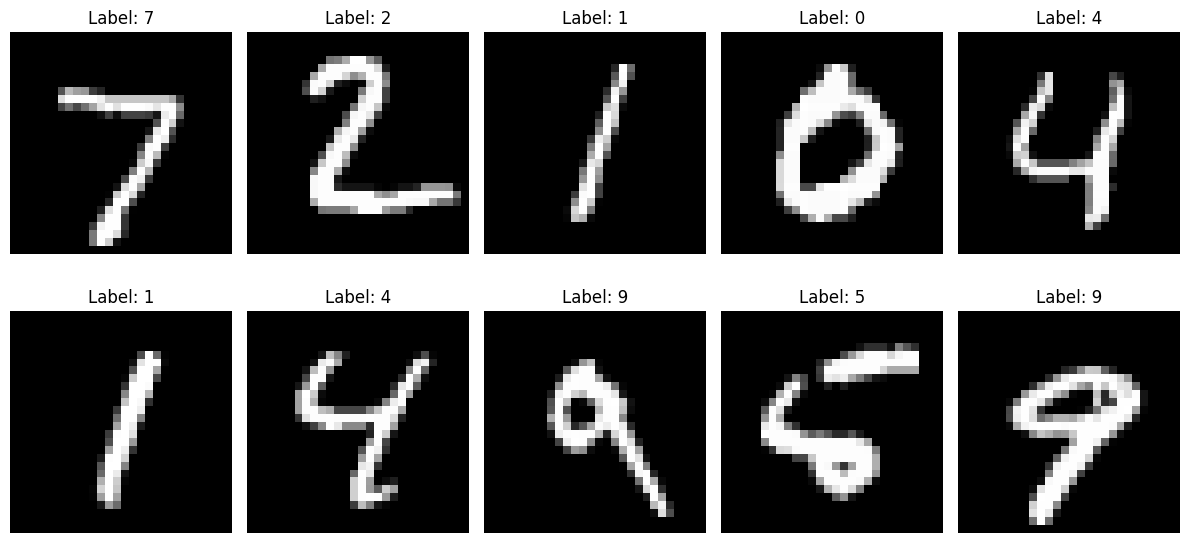

In [6]:
def display_images(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()

    for idx in range(10):
        axes[idx].imshow(images[idx].squeeze(), cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f'Label: {labels[idx].item()}')

    plt.tight_layout()
    plt.show()

display_images(test_loader)

In [7]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28 * 28, 10)  # MNIST images are 28x28

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LogisticRegression().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [9]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


In [10]:
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    return test_loss, test_acc

In [11]:
num_epochs = 10
train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1} / {num_epochs}]")
    print(f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_acc:.2f}")
    print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")
    print('-' * 60)

Epoch [1 / 10]
Train Loss: 0.48, Train Accuracy: 87.41
Test Loss: 0.34, Test Accuracy: 90.84
------------------------------------------------------------
Epoch [2 / 10]
Train Loss: 0.34, Train Accuracy: 90.58
Test Loss: 0.31, Test Accuracy: 91.54
------------------------------------------------------------
Epoch [3 / 10]
Train Loss: 0.31, Train Accuracy: 91.23
Test Loss: 0.29, Test Accuracy: 91.90
------------------------------------------------------------
Epoch [4 / 10]
Train Loss: 0.30, Train Accuracy: 91.56
Test Loss: 0.29, Test Accuracy: 91.80
------------------------------------------------------------
Epoch [5 / 10]
Train Loss: 0.29, Train Accuracy: 91.78
Test Loss: 0.28, Test Accuracy: 92.18
------------------------------------------------------------
Epoch [6 / 10]
Train Loss: 0.29, Train Accuracy: 91.94
Test Loss: 0.28, Test Accuracy: 92.12
------------------------------------------------------------
Epoch [7 / 10]
Train Loss: 0.28, Train Accuracy: 92.08
Test Loss: 0.28, Test

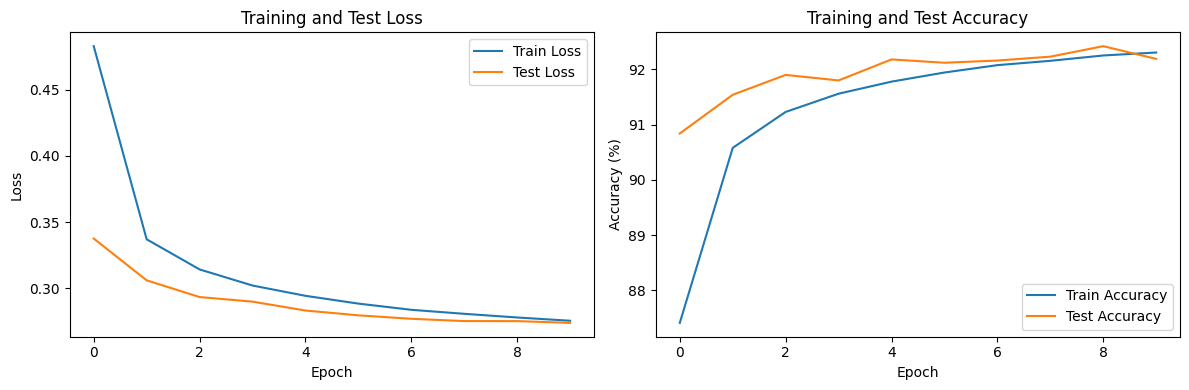

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

In [14]:
def display_predictions(model, test_loader, device, num_images=10):
    images, labels = next(iter(test_loader))
    images = images[:num_images].to(device)
    labels = labels[:num_images]

    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()

    for idx in range(num_images):
        axes[idx].imshow(images[idx].cpu().squeeze(), cmap='gray')
        axes[idx].axis('off')
        correct = "✓" if predicted[idx] == labels[idx] else "✗"
        axes[idx].set_title(f'Pred: {predicted[idx]}\nTrue: {labels[idx]} {correct}')

    plt.tight_layout()
    plt.show()

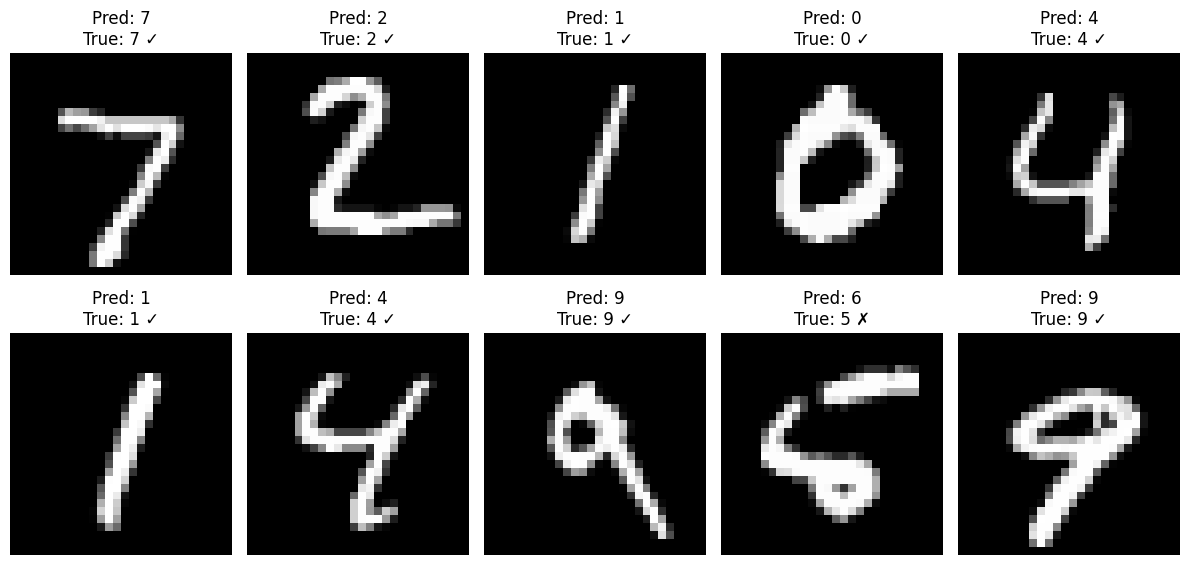

In [15]:
display_predictions(model, test_loader, device)